# 수업 개요 

  1. MovieLens 데이터 살펴보기
  1. 준비작업
  1. Matrix Factorization 학습하기
  1. 임베딩 이해하기
  1. Matrix Factorization 정규화하기
  1. 소프트맥스 모델 학습하기

- 실습은 [MovieLens](https://movielens.org/) 데이터로 진행하고, 데이터는 영화에 대한 평점을 담고 있습니다. 평점은 1부터 5점사이에서 이루어집니다. 
- 이 노트북은 [추천시스템 실습](https://developers.google.com/machine-learning/recommendation/)을 참고하였으며, Matrix Factorization에 대한 주된 내용을 다룰 것입니다.


In [4]:
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

# Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

# Install spreadsheets and import authentication module.
USER_RATINGS = False
!pip install --upgrade -q gspread
# from google.colab import auth
# import gspread
# from oauth2client.client import GoogleCredentials

Installing Altair...
  Cloning git://github.com/altair-viz/altair.git to /private/var/folders/8x/6g4g5kpd3j51mchmrx1m92vm0000gn/T/pip-req-build-c7_z9n2p
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for altair: filename=altair-4.2.0.dev0-py3-none-any.whl size=730030 sha256=804408bf68b17f15f3467a90c7e3ba151ab61d77a99ffdf5cb570a4c970ce213
  Stored in directory: /private/var/folders/8x/6g4g5kpd3j51mchmrx1m92vm0000gn/T/pip-ephem-wheel-cache-to6gw9dw/wheels/06/13/e0/5bd72c969fe3954ee1561739e5c58e2ddfe5c10fcdffb12faa
Successfully built altair
Done installing Altair.


- MovieLens 데이터를 다운받고, dataframe형태로 변환하여 영화, 사용자, 평점 등 관계를 파악해보자.

In [5]:
# Download MovieLens data.
print("Downloading movielens data...")
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

# Compute the number of movies to which a genre is assigned.
genre_occurences = movies[genre_cols].sum().to_dict()

# Since some movies can belong to more than one genre, we create different
# 'genre' columns as follows:
# - all_genres: all the active genres of the movie.
# - genre: randomly sampled from the active genres.
def mark_genres(movies, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)
  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return '-'.join(active)
  movies['genre'] = [
      get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
  movies['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

# Create one merged DataFrame containing all the movielens data.
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


# 1. MovieLens 데이터 분석하기

### 영화 관객 데이터 분석 

In [6]:
users.describe()

,age
count,943.000
mean,34.052
std,12.193
min,7.000
25%,25.000
50%,31.000
75%,43.000
max,73.000


In [7]:
users.describe(include=[np.object])

,user_id,sex,occupation,zip_code
count,943,943,943,943
unique,943,2,21,795
top,690,M,student,55414
freq,1,670,196,9


In [8]:
# Create filters to be used to slice the data.
occupation_filter = alt.selection_multi(fields=["occupation"])
occupation_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y("occupation:N"),
    color=alt.condition(
        occupation_filter,
        alt.Color("occupation:N", scale=alt.Scale(scheme='category20')),
        alt.value("lightgray")),
).properties(width=300, height=300, selection=occupation_filter)

# A function that generates a histogram of filtered data.
def filtered_hist(field, label, filter):
  """Creates a layered chart of histograms.
  The first layer (light gray) contains the histogram of the full data, and the
  second contains the histogram of the filtered data.
  Args:
    field: the field for which to generate the histogram.
    label: String label of the histogram.
    filter: an alt.Selection object to be used to filter the data.
  """
  base = alt.Chart().mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
      y="count()",
  ).properties(
      width=300,
  )
  return alt.layer(
      base.transform_filter(filter),
      base.encode(color=alt.value('lightgray'), opacity=alt.value(.7)),
  ).resolve_scale(y='independent')


- 관객별 평점 분포 데이터를 히스토그램으로 직접 그려보자.
- Altair 라이브러리를 사용하면 좀 더 멋진 시각화를 볼 수 있다. 

In [9]:
users_ratings = (
    ratings
    .groupby('user_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols()
    .merge(users, on='user_id')
)

# Create a chart for the count, and one for the mean.
alt.hconcat(
    filtered_hist('rating count', '# ratings / user', occupation_filter),
    filtered_hist('rating mean', 'mean user rating', occupation_filter),
    occupation_chart,
    data=users_ratings)

alt.HConcatChart(...)

### 영화 데이터 분석
- 영화 데이터에서 좋은 정보를 얻어낼 수 있는지 살펴보자

In [10]:
movies_ratings = movies.merge(
    ratings
    .groupby('movie_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='movie_id')

genre_filter = alt.selection_multi(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300, selection=genre_filter)

In [11]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .sort_values('rating count', ascending=False)
 .head(10))

,title,rating count,rating mean
49,Star Wars (1977),583,4.358
257,Contact (1997),509,3.804
99,Fargo (1996),508,4.156
180,Return of the Jedi (1983),507,4.008
293,Liar Liar (1997),485,3.157
285,"English Patient, The (1996)",481,3.657
287,Scream (1996),478,3.441
0,Toy Story (1995),452,3.878
299,Air Force One (1997),431,3.631
120,Independence Day (ID4) (1996),429,3.438


In [12]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .mask('rating count', lambda x: x > 20)
 .sort_values('rating mean', ascending=False)
 .head(10))

,title,rating count,rating mean
407,"Close Shave, A (1995)",112,4.491
317,Schindler's List (1993),298,4.466
168,"Wrong Trousers, The (1993)",118,4.466
482,Casablanca (1942),243,4.457
113,Wallace & Gromit: The Best of Aardman Animatio...,67,4.448
63,"Shawshank Redemption, The (1994)",283,4.445
602,Rear Window (1954),209,4.388
11,"Usual Suspects, The (1995)",267,4.386
49,Star Wars (1977),583,4.358
177,12 Angry Men (1957),125,4.344


- 마지막으로 데이터의 전체 평점 수와 평균 평점을 분석해보자

In [13]:
# Display the number of ratings and average rating per movie.
alt.hconcat(
    filtered_hist('rating count', '# ratings / movie', genre_filter),
    filtered_hist('rating mean', 'mean movie rating', genre_filter),
    genre_chart,
    data=movies_ratings)

alt.HConcatChart(...)

# 2. 사전 정보

- 평점 행렬 $A$를 $A \approx UV^\top$ 로 분해
- 유저 임베딩 행렬 $U$과 영화 임베딩 행렬 $V$
- 여기서 $U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ and
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$.

Notation을 확인해보자.
- $N$ 은 평점을 매긴 영화 관객 수
- $M$ 은 전체 영화 수
- $A_{ij}$ $i$번째 관객의 $j$번째 영화 평점
- 행 $U_i$은 $d$-차원 임베딩으로 관객 $i$
- 행 $V_j$은 $d$-차원 임베딩으로 영화 $j$
- $(i, j)$ 쌍에 대한 모델 예측은  $\langle U_i, V_j \rangle$ 내적합으로 나타낸다


## 평점 행렬은 Sparse Matrix(Representation)이다

- 평점 행렬은 매우 크고, 일반적으로 관객들이 모든 영화에 대해서 평가하지 않기 때문에 많은 영화 항목들이 missing value이다. 
- `SparseTensor`: `tf.SparseTensor(indices, values, dense_shape)`
- [tf.SparseTensor](https://www.tensorflow.org/api_docs/python/tf/SparseTensor) 참고

#### Sparse Matrix 예시
예를들어 $2$명의 관객과 $4$개의 영화가 있다고 하자. 

user\_id | movie\_id | rating
--:|--:|--:
0 | 0 | 5.0
0 | 1 | 3.0
1 | 3 | 1.0

위의 dataframe을 평점행렬로 바꾸면 다음과 같다.

$$
A =
\begin{bmatrix}
5.0 & 3.0 & 0 & 0 \\
0   &   0 & 0 & 1.0
\end{bmatrix}
$$

위의 예시를 SparseTensor로 활용해서 표현한다면 다음과 같다.
```python
SparseTensor(
  indices=[[0, 0], [0, 1], [1,3]],
  values=[5.0, 3.0, 1.0],
  dense_shape=[2, 4])
```



### tf.SparseTensor를 활용하여 평점 행렬 구성

- 다음 파이썬 함수는 `ratings` dataframe을 `tf.SparseTensor`로 형태로 변환한다.


In [14]:
def build_rating_sparse_tensor(ratings_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    a tf.SparseTensor representing the ratings matrix.
  """
  indices = ratings_df[['user_id', 'movie_id']].values
  values = ratings_df['rating'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

## 에러를 계산한다

- 모델의 평점 행렬 $A$에 대한 예측 에러를 계산해야한다.
- MSE(Mean Squared Error)를 활용하여 에러를 계산해보자.
- 수식은 다음과 같이 정의할 수 있다.

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$
- 여기서 $\Omega$ 는 전체 평점 집합을 의미하고, $|\Omega|$ 는 $\Omega$의 집합 크기이다.


### MSE(Mean Squared Error)를 구하는 함수 구현

- Input: Sparse한 평점행렬 $A$ 와 관객과 평점에 관한 임베딩 행렬 $U, V$
- Output: $\text{MSE}(A, UV^\top)$ 값.
- `SparseTensor` (`sp_x`) 는 (`sp_x.indices`, `sp_x.values`, `sp_x.dense_shape`) 튜플형태이다.
- 참고: [`tf.gather_nd`](https://www.tensorflow.org/api_docs/python/tf/gather_nd)와  [`tf.losses.mean_squared_error`](https://www.tensorflow.org/api_docs/python/tf/losses/mean_squared_error)

In [15]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings, movie_embeddings
  Returns:
    Tensor representation for MSE between true value and predicted value
  """
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, movie_embeddings, transpose_b=True),
      sparse_ratings.indices)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

Note: One approach is to compute the full prediction matrix $UV^\top$, then gather the entries corresponding to the observed pairs. The memory cost of this approach is $O(NM)$. For the MovieLens dataset, this is fine, as the dense $N \times M$ matrix is small enough to fit in memory ($N = 943$, $M = 1682$).

Another approach (given in the alternate solution below) is to only gather the embeddings of the observed pairs, then compute their dot products. The memory cost is $O(|\Omega| d)$ where $d$ is the embedding dimension. In our case, $|\Omega| = 10^5$, and the embedding dimension is on the order of $10$, so the memory cost of both methods is comparable. But when the number of users or movies is much larger, the first approach becomes infeasible.

# 3. Matrix Factorization 모델

## 협업필터링 helper class
- Stochastic Gradient Descent(SGD)로 학습하는 Matrix Factorization 모델 구현하기 위해 간단한 클래스를 구현하여 활용한다.

Class의 Input은 다음과 같다.
- 관객 임베딩 U (a `tf.Variable`).
- 영화 임베딩 V, (a `tf.Variable`).
- 학습해야할(최적화) loss (a `tf.Tensor`).

학습이 끝나면 `model.embeddings` 를 이용해서 학습된 임베딩을 확인할 수 있다.

다음을 참고하자.
```
U_var = ...
V_var = ...
loss = ...
model = CFModel(U_var, V_var, loss)
model.train(iterations=100, learning_rate=1.0)
user_embeddings = model.embeddings['user_id']
movie_embeddings = model.embeddings['movie_id']
```


In [16]:
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

### Matrix Factorization model 함수를 만들고 학습해보자!

- `build_rating_sparse_tensor`,`sparse_mean_square_error` 함수와 `CFModel` 클래스를 활용하여 다음 함수를 완성하고 학습하자.
- 학습이 되면서 train과 test loss를 함께 확인해보자.

In [17]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal([A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal([A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)

  metrics = {
      'train_loss': train_loss,
      'test_loss': test_loss
  }
  embeddings = {
      "user_id": U,
      "movie_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

- 이제 직접 학습을 해보자. `model.train`로 바로 학습해볼 수 있다.
- 이 때, 각종 파라미터를 바꿔가면서 학습해서 loss가 어떻게 변하는지 확인해볼 수 있다.

 iteration 1000: train_loss=0.376795, test_loss=1.334094

[{'train_loss': 0.37679532, 'test_loss': 1.3340943}]

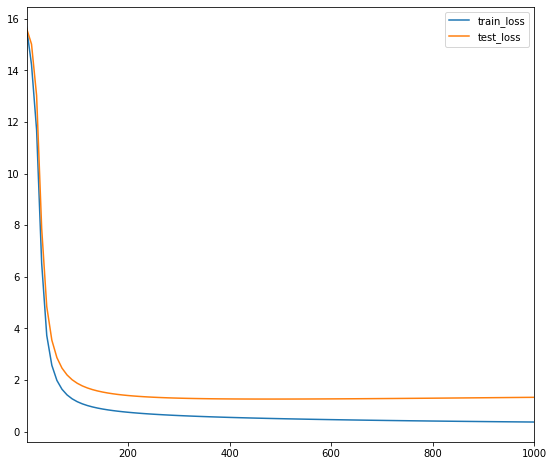

In [18]:
# Build the CF model and train it.
model = build_model(ratings, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

# 4. 학습해서 얻은 임베딩, 자세히 살펴보기

1. 추천 점수를 계산한다.
1. 특정 영화와 임베딩 공간에서 가장 가까이있는 영화 확인한다.
1. 영화 임베딩의 norm 확인한다.
1. 임베딩 공간에 모델이 학습한 임베딩을 시각화한다.


### 모델의 추천 후보에 대한 추천 점수 계산

- Query embedding $u \in \mathbb R^d$ 과 Item embeddings $V \in \mathbb R^{N \times d}$로 아이템 점수를 계산한다.
- [`np.dot`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html)을 활용하여 dot product $\langle u, V_j \rangle$ 계산한다.
- [`np.linalg.norm`](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.norm.html)을 활용하여 $\frac{\langle u, V_j \rangle}{\|u\|\|V_j\|}$ 계산한다.


In [19]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  if measure=='DOT':
    scores = np.dot(query_embedding, item_embeddings)
  else:
    scores = np.dot(query_embedding, item_embeddings.T)/(np.linalg.norm(query_embedding)*np.linalg.norm(item_embeddings.T))

  return scores

In [20]:
def user_recommendations(model, measure=DOT, exclude_rated=False, k=6):
  if USER_RATINGS:
    scores = compute_scores(
        model.embeddings["user_id"][943], model.embeddings["movie_id"], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'movie_id': movies['movie_id'],
        'titles': movies['title'],
        'genres': movies['all_genres'],
    })
    if exclude_rated:
      # remove movies that are already rated
      rated_movies = ratings[ratings.user_id == "943"]["movie_id"].values
      df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]
    display.display(df.sort_values([score_key], ascending=False).head(k))  

def movie_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for movie ids that match the given substring.
  ids =  movies[movies['title'].str.contains(title_substring)].index.values
  titles = movies.iloc[ids]['title'].values
  if len(titles) == 0:
    raise ValueError("Found no movies with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching movie. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  movie_id = ids[0]
  scores = compute_scores(
      model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': movies['title'],
      'genres': movies['all_genres']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

### 가장 가까운 영화! 가장 비슷한 영화는?
- 영화의 Nearest Neighbors 찾기

In [21]:
movie_neighbors(model, "Aladdin", DOT)
movie_neighbors(model, "Aladdin", COSINE)

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


,dot score,titles,genres
94,0.020,Aladdin (1992),Animation-Children-Comedy-Musical
1018,0.018,"Die xue shuang xiong (Killer, The) (1989)",Action-Thriller
393,0.018,Radioland Murders (1994),Comedy-Mystery-Romance
317,0.018,Schindler's List (1993),Drama-War
312,0.018,Titanic (1997),Action-Drama-Romance
142,0.018,"Sound of Music, The (1965)",Musical


Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


,cosine score,titles,genres
94,0.020,Aladdin (1992),Animation-Children-Comedy-Musical
1018,0.018,"Die xue shuang xiong (Killer, The) (1989)",Action-Thriller
393,0.018,Radioland Murders (1994),Comedy-Mystery-Romance
317,0.018,Schindler's List (1993),Drama-War
312,0.018,Titanic (1997),Action-Drama-Romance
142,0.018,"Sound of Music, The (1965)",Musical



## 영화 임베딩 시각화
- 임베딩 벡터의 norm을 활용한다.

In [22]:
# @title Embedding Visualization code (run this cell)

def movie_embedding_norm(models):
  """Visualizes the norm and number of ratings of the movie embeddings.
  Args:
    model: A MFModel object.
  """
  if not isinstance(models, list):
    models = [models]
  df = pd.DataFrame({
      'title': movies['title'],
      'genre': movies['genre'],
      'num_ratings': movies_ratings['rating count'],
  })
  charts = []
  brush = alt.selection_interval()
  for i, model in enumerate(models):
    norm_key = 'norm'+str(i)
    df[norm_key] = np.linalg.norm(model.embeddings["movie_id"], axis=1)
    nearest = alt.selection(
        type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
        empty='none')
    base = alt.Chart().mark_circle().encode(
        x='num_ratings',
        y=norm_key,
        color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
    ).properties(
        selection=nearest).add_selection(brush)
    text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
        x='num_ratings', y=norm_key,
        text=alt.condition(nearest, 'title', alt.value('')))
    charts.append(alt.layer(base, text))
  return alt.hconcat(*charts, data=df)

def visualize_movie_embeddings(data, x, y):
  nearest = alt.selection(
      type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
      empty='none')
  base = alt.Chart().mark_circle().encode(
      x=x,
      y=y,
      color=alt.condition(genre_filter, "genre", alt.value("whitesmoke")),
  ).properties(
      width=600,
      height=600,
      selection=nearest)
  text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
      x=x,
      y=y,
      text=alt.condition(nearest, 'title', alt.value('')))
  return alt.hconcat(alt.layer(base, text), genre_chart, data=data)

def tsne_movie_embeddings(model):
  """Visualizes the movie embeddings, projected using t-SNE with Cosine measure.
  Args:
    model: A MFModel object.
  """
  tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

  print('Running t-SNE...')
  V_proj = tsne.fit_transform(model.embeddings["movie_id"])
  movies.loc[:,'x'] = V_proj[:, 0]
  movies.loc[:,'y'] = V_proj[:, 1]
  return visualize_movie_embeddings(movies, 'x', 'y')

In [23]:
movie_embedding_norm(model)

alt.HConcatChart(...)

 iteration 1000: train_loss=0.353214, test_loss=0.977957Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


,dot score,titles,genres
94,0.031,Aladdin (1992),Animation-Children-Comedy-Musical
495,0.027,It's a Wonderful Life (1946),Drama
171,0.027,"Empire Strikes Back, The (1980)",Action-Adventure-Drama-Romance-Sci-Fi-War
185,0.027,"Blues Brothers, The (1980)",Action-Comedy-Musical
173,0.026,Raiders of the Lost Ark (1981),Action-Adventure
587,0.026,Beauty and the Beast (1991),Animation-Children-Musical


Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


,cosine score,titles,genres
94,0.031,Aladdin (1992),Animation-Children-Comedy-Musical
495,0.027,It's a Wonderful Life (1946),Drama
171,0.027,"Empire Strikes Back, The (1980)",Action-Adventure-Drama-Romance-Sci-Fi-War
185,0.027,"Blues Brothers, The (1980)",Action-Comedy-Musical
173,0.026,Raiders of the Lost Ark (1981),Action-Adventure
587,0.026,Beauty and the Beast (1991),Animation-Children-Musical


alt.HConcatChart(...)

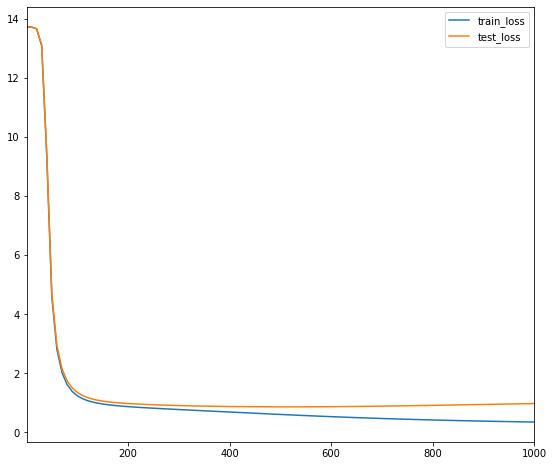

In [24]:
model_lowinit = build_model(ratings, embedding_dim=30, init_stddev=0.05)
model_lowinit.train(num_iterations=1000, learning_rate=10.)
movie_neighbors(model_lowinit, "Aladdin", DOT)
movie_neighbors(model_lowinit, "Aladdin", COSINE)
movie_embedding_norm([model, model_lowinit])

## t-SNE로 임베딩 시각화

In [25]:
tsne_movie_embeddings(model_lowinit)

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.000s...
[t-SNE] Computed neighbors for 1682 samples in 0.102s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682
[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.117257
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.145199
[t-SNE] KL divergence after 400 iterations: 2.195530


alt.HConcatChart(...)

# 4. 소프트맥스 모델

- 간단한 소프트맥스 모델을 학습합니다.
- 모델은 $x$를 input으로 받아서 학습하는데 $x$는 관객이 평점을 준 영화 벡터이다. 

아래의 그림을 참고하자.

![Softmax model](https://github.com/google/eng-edu/blob/master/ml/recommendation-systems/images/softmax-model.png?raw=true)


In [26]:
rated_movies = (ratings[["user_id", "movie_id"]]
                .groupby("user_id", as_index=False)
                .aggregate(lambda x: list(x)))
rated_movies.head()

,user_id,movie_id
0,0,"[60, 188, 32, 159, 19, 201, 170, 264, 154, 116..."
1,1,"[291, 250, 49, 313, 296, 289, 311, 280, 12, 27..."
2,10,"[110, 557, 731, 226, 424, 739, 722, 37, 724, 1..."
3,100,"[828, 303, 595, 221, 470, 404, 280, 251, 281, ..."
4,101,"[767, 822, 69, 514, 523, 321, 624, 160, 447, 4..."


각 batch example은 다음과 같은 feature를 포함하고 있다.

- movie_id: A tensor of strings of the movie ids that the user rated.
- genre: A tensor of strings of the genres of those movies
- year: A tensor of strings of the release year.

In [27]:
years_dict = {
    movie: year for movie, year in zip(movies["movie_id"], movies["year"])
}
genres_dict = {
    movie: genres.split('-')
    for movie, genres in zip(movies["movie_id"], movies["all_genres"])
}

def make_batch(ratings, batch_size):
  """Creates a batch of examples.
  Args:
    ratings: A DataFrame of ratings such that examples["movie_id"] is a list of
      movies rated by a user.
    batch_size: The batch size.
  """
  def pad(x, fill):
    return pd.DataFrame.from_dict(x).fillna(fill).values

  movie = []
  year = []
  genre = []
  label = []
  for movie_ids in ratings["movie_id"].values:
    movie.append(movie_ids)
    genre.append([x for movie_id in movie_ids for x in genres_dict[movie_id]])
    year.append([years_dict[movie_id] for movie_id in movie_ids])
    label.append([int(movie_id) for movie_id in movie_ids])
  features = {
      "movie_id": pad(movie, ""),
      "year": pad(year, ""),
      "genre": pad(genre, ""),
      "label": pad(label, -1)
  }
  batch = (
      tf.data.Dataset.from_tensor_slices(features)
      .shuffle(1000)
      .repeat()
      .batch(batch_size)
      .make_one_shot_iterator()
      .get_next())
  return batch

def select_random(x):
  """Selectes a random elements from each row of x."""
  def to_float(x):
    return tf.cast(x, tf.float32)
  def to_int(x):
    return tf.cast(x, tf.int64)
  batch_size = tf.shape(x)[0]
  rn = tf.range(batch_size)
  nnz = to_float(tf.count_nonzero(x >= 0, axis=1))
  rnd = tf.random_uniform([batch_size])
  ids = tf.stack([to_int(rn), to_int(nnz * rnd)], axis=1)
  return to_int(tf.gather_nd(x, ids))
